## BERT 

In [1]:
import pickle
import pandas as pd
lop = pd.read_pickle('output/avg_2_bert100_16387.pkl', compression='gzip')

In [2]:
ok = [y for x in lop for y in x]
abc = pd.DataFrame(ok, columns = ['first_token', 'second_token', 'st', 'lot', 'ig', 'row_index'])
new_abc = abc.explode(['st', 'lot','row_index'])
new_abc['posdis'] = new_abc['second_token'] - new_abc['first_token']
new_abc = new_abc.rename(columns = {'row_index' : 'row_number', 'st' : 'tensor'})[['tensor', 'posdis', 'row_number', 'first_token', 'second_token']]
new_abc['predicted_token_dist_from_start'] = new_abc[['tensor']].apply(lambda x : list(range(0, 0 + len(x['tensor']))), axis=1)
new_abc = new_abc.explode(['tensor', 'predicted_token_dist_from_start'])
new_abc['tensor'] = new_abc['tensor'].apply(lambda x : float(x))
new_abc['min_dist'] = new_abc['predicted_token_dist_from_start'] - new_abc['second_token']

In [3]:
from experiment_runner import *
self = ExperimentRunner(cuda=True, seq_len=20, model_name = 'bert', method=105)

In [4]:
self.prepare_data()

In [5]:
from itertools import combinations
mwe = self.test.reset_index(drop=True).reset_index()
mwe = mwe[['index', 'weak_mwe', 'strong_mwe']].copy()
mwe['weak_toks'] = mwe['weak_mwe'].apply(lambda x : [list(combinations(y, 2)) for y in x])
mwe = mwe.explode(['weak_mwe', 'weak_toks']).explode('weak_toks')
mwe = mwe.rename(columns = {'index' : 'row_number'})
mwe[['first_token', 'second_token']] = pd.DataFrame(mwe['weak_toks'].tolist(), index=mwe.index)
mwe = mwe.dropna(subset=['first_token', 'second_token'])
mwe[['first_token', 'second_token']] = mwe[['first_token', 'second_token']].astype(int)
mwe['posdis'] = mwe['second_token'] - mwe['first_token']
mwe = mwe[['row_number', 'first_token', 'second_token', 'posdis']].copy()
new_mwe = new_abc.merge(mwe, on = ['row_number','first_token','second_token','posdis'])
new_mwe

,row_number,first_token,second_token,posdis
0,0,30,31,1
1,1,15,16,1
1,1,15,17,2
1,1,15,18,3
1,1,16,17,1
...,...,...,...,...
58825,58825,22,23,1
58826,58826,12,13,1
58827,58827,12,13,1
58828,58828,23,24,1


In [29]:
from itertools import combinations
mwe = self.test.reset_index(drop=True).reset_index()
mwe = mwe[['index',  'strong_mwe']].copy()
mwe['strong_toks'] = mwe['strong_mwe'].apply(lambda x : [list(combinations(y, 2)) for y in x])
mwe = mwe.explode(['strong_mwe', 'strong_toks']).explode('strong_toks')
mwe = mwe.rename(columns = {'index' : 'row_number'})
mwe = mwe.dropna(subset=['strong_mwe'])
mwe[['first_token', 'second_token']] = pd.DataFrame(mwe['strong_toks'].tolist(), index=mwe.index)
mwe = mwe.dropna(subset=['first_token', 'second_token'])
mwe[['first_token', 'second_token']] = mwe[['first_token', 'second_token']].astype(int)
mwe['posdis'] = mwe['second_token'] - mwe['first_token']
mwe = mwe[['row_number', 'first_token', 'second_token', 'posdis']].copy()
strong_mwe = new_abc.merge(mwe, on = ['row_number','first_token','second_token','posdis'])
strong_mwe

,tensor,posdis,row_number,first_token,second_token,predicted_token_dist_from_start,min_dist
0,0.119202,1,116,16,17,0,-17
1,0.221600,1,116,16,17,1,-16
2,0.124159,1,116,16,17,2,-15
3,0.125317,1,116,16,17,3,-14
4,0.171868,1,116,16,17,4,-13
...,...,...,...,...,...,...,...
12075,0.158098,1,16352,3,4,15,11
12076,0.170522,1,16352,3,4,16,12
12077,0.163830,1,16352,3,4,17,13
12078,0.168938,1,16352,3,4,18,14


In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def plot(strong_df, weak_df, avg_df):
    fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True, sharex=True)
    strong_df = strong_df.rename(columns = {'posdis': f'$d_i$', 'tensor': 'STII'})
    weak_df = weak_df.rename(columns = {'posdis': f'$d_i$', 'tensor': 'STII'})
    avg_df = avg_df.rename(columns = {'posdis': f'$d_i$', 'tensor': 'STII'})

    strong_df = strong_df[strong_df[f'$d_i$'] <= 4]
    weak_df = weak_df[weak_df[f'$d_i$'] <= 4]
    avg_df = avg_df[avg_df[f'$d_i$'] <= 4]

    for i in range(-3, 3):
        for j in [0]:
            min_dist = j*4 + i + 1
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x=f'$d_i$', y="STII", ax=axes[i], label='strong mwe')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x=f'$d_i$', y="STII", ax=axes[i], label='weak mwe')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x=f'$d_i$', y="STII", ax=axes[i], label='all')
            axes[i].set_title(f'$d_p$ = {min_dist}')
            # if i != 2:
            # axes[i].set_xlabel(f'$d_i$', labelpad=-5)
            handles, labels = axes[i].get_legend_handles_labels()
            axes[i].get_legend().remove()
    # plt.legend()
    plt.subplots_adjust(bottom=0.5)
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=3)
    plt.tight_layout()
    plt.savefig('alm_experiment', bbox_inches='tight')
    plt.show()

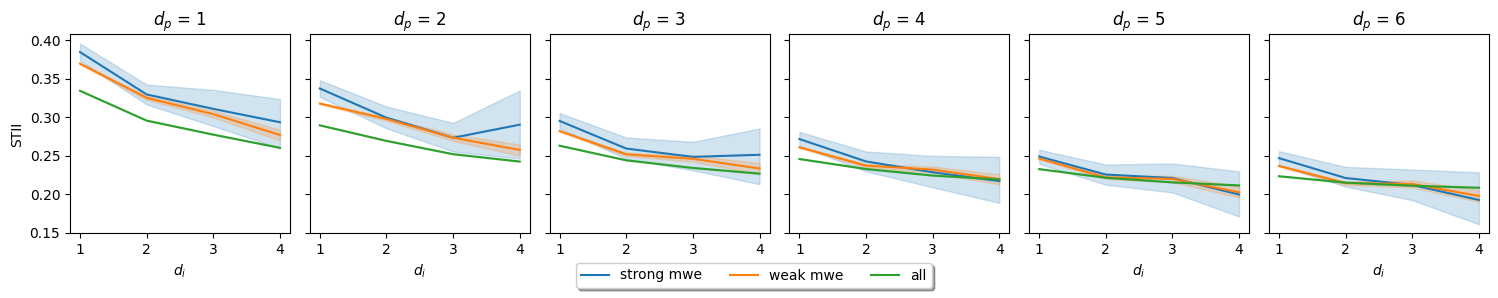

In [33]:
plot(strong_mwe, new_mwe, new_abc)

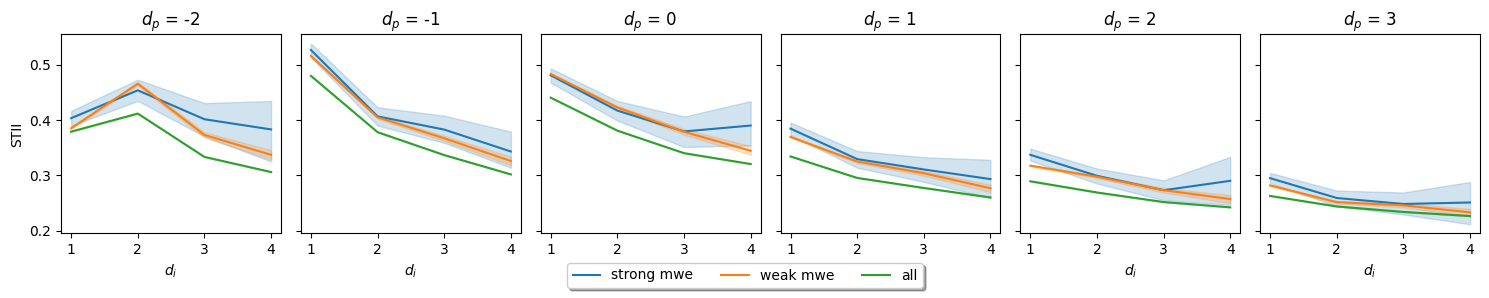

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def plot(strong_df, weak_df, avg_df):
    fig, axes = plt.subplots(1, 6, figsize=(15, 3), sharey=True, sharex=True)
    strong_df = strong_df.rename(columns = {'posdis': f'$d_i$', 'tensor': 'STII'})
    weak_df = weak_df.rename(columns = {'posdis': f'$d_i$', 'tensor': 'STII'})
    avg_df = avg_df.rename(columns = {'posdis': f'$d_i$', 'tensor': 'STII'})

    strong_df = strong_df[strong_df[f'$d_i$'] <= 4]
    weak_df = weak_df[weak_df[f'$d_i$'] <= 4]
    avg_df = avg_df[avg_df[f'$d_i$'] <= 4]

    for i in range(0, 6):
        for j in [0]:
            min_dist = j*4 + i - 2
            
            strong_line = sns.lineplot(data=strong_df[strong_df['min_dist'] ==min_dist], x=f'$d_i$', y="STII", ax=axes[i], label='strong mwe')
            weak_line = sns.lineplot(data=weak_df[weak_df['min_dist'] ==min_dist], x=f'$d_i$', y="STII", ax=axes[i], label='weak mwe')
            avg_line = sns.lineplot(data=avg_df[avg_df['min_dist'] == min_dist], x=f'$d_i$', y="STII", ax=axes[i], label='all')
            axes[i].set_title(f'$d_p$ = {min_dist}')
            # if i != 2:
            # axes[i].set_xlabel(f'$d_i$', labelpad=-5)
            handles, labels = axes[i].get_legend_handles_labels()
            axes[i].get_legend().remove()
    # plt.legend()
    plt.subplots_adjust(bottom=0.5)
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=3)
    plt.tight_layout()
    plt.savefig('alm_experiment', bbox_inches='tight')
    plt.show()

plot(strong_mwe, new_mwe, new_abc)